<a href="https://colab.research.google.com/github/Dureduran/Coursera_Capstone/blob/main/An_unsupervised_machine_learning_approach_to_dicover_Toronto_neighborhoods_to_open_a_Coffee_Shop_Franchise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **An unsupervised machine learning approach to dicover Toronto neighborhoods to open a Coffee Shop Franchise.**


## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)



## Introduction<a name="introduction"></a>

Toronto has a sprawling neighborhood with popular coffee chains like StarBucks, Tim Hortons and Second Cup found almost in every nook and cranny. Torontians love their coffee! This report aims to find areas in Toronto for coffee chains to expand to.\
**Business Problem: \
 Which Toronto Neighborhood should a Coffee Franchise expand to?**




---


We will first collect data for Toronto neighborhoods and utilize an supervized machine learning approach (k-means) to cluster similar neighborhoods and analyze to discover potential neighborhoods for a Coffee Franchise to expand to.

---

>




**Installing relevant packages**

In [1]:
!pip install lxml
!pip install bs4
!pip install html5lib
!pip install wordcloud
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import requests  # library to handle requests
import json  # library to handle JSON files
import matplotlib.colors as colors
import matplotlib.cm as cm
from sklearn.cluster import KMeans
import folium  # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import numpy as np
import pandas as pd
import numpy
from bs4 import BeautifulSoup
from wordcloud import WordCloud


##Data <a name="data"></a>
**Data Sources:**


1.   Webscraping Toronto Neighbourhood Data from Wikipedia:                 
  Source: ("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'")
2.   Toronto Coordinates Data \
    Source: ('https://cocl.us/Geospatial_data') 

3. 4-square API venues Data\
Source: ("https://api.foursquare.com/v2/venues/explore")


We will first extract data from wikipedia, preprocess to clean and transform the data into a tabular form. \
Secondly we will merge our webscraped data to Toroto Coordinates data with lat itude and longitutde coordinate values.\
Finally we will extract coffee venues data from 4-square API. After cleaning repitive names for the same chain like 'tim hortons'and 'Tim Horton's'; we will finally merge this venues data with our Toronto Coordinates, Neighborhoods and Postal Code Data and have a master table produced from the 3 sources above.

###Webscraping Toronto Neighbourhood Data from Wikipedia

In [2]:
url='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
data  = requests.get(url).text

In [3]:
soup = BeautifulSoup(data,"html5lib")

In [4]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df=pd.DataFrame(table_contents)
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

df.rename(columns={'PostalCode': 'Postal Code'}, inplace=True)
df

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto Business,Enclave of M4L
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


In [5]:
df.shape

(103, 3)

###Toronto Coordinates Data


In [6]:
lat_lng_coords = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [7]:
df_new = pd.merge(df,lat_lng_coords,on='Postal Code')
df_new

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


###4-square API venues Data

In [8]:
CLIENT_ID = 'L5ZTQ2K5OYU23HLD3K1F0SCO1BH2MQU5LPTV4QQEDGJUCYPT' # your Foursquare ID
CLIENT_SECRET = 'YYS3Z0MD4WTRQQOVLHFYDNMKPUKA20VA0UU5EJ3HP2KDYQI0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value
CATEGORY_ID = '4bf58dd8d48988d1e0931735'  # Coffee Shop

Function to return nearby venues.



Toronto is a large city hence the radius is set to 1000m

In [9]:
#FUNCTION to get data from foursquareAPI from lat,long values


def getNearbyVenues(names, latitudes, longitudes, radius=1000):

    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            CATEGORY_ID,
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            lat,
            lng,
            v['venue']['name'],
            v['venue']['location']['lat'],
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame(
        [item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'Neighborhood Latitude',
                             'Neighborhood Longitude',
                             'Venue',
                             'Venue Latitude',
                             'Venue Longitude',
                             'Venue Category']
    
    return(nearby_venues)
    print("Done!:)")

Code to run the above function on each neighborhood and create a new dataframe called toronto_venues.

In [10]:
toronto_venues = getNearbyVenues(names=df_new['Neighborhood'],
                                   latitudes=df_new['Latitude'],
                                   longitudes=df_new['Longitude']
                                  )

In [11]:
print(toronto_venues.shape)
toronto_venues.head()

(2048, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Tim Hortons,43.760668,-79.326368,Café
1,Parkwoods,43.753259,-79.329656,La Notre,43.760704,-79.325396,Coffee Shop
2,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
3,Victoria Village,43.725882,-79.315572,Tim Hortons,43.727082,-79.327143,Coffee Shop
4,Victoria Village,43.725882,-79.315572,Cafe Bellevue,43.724201,-79.327285,Café


###Data Cleaning

In [12]:
#Looking at unique venue names
#Tim Hortons
toronto_venues['Venue'] = pd.DataFrame(toronto_venues['Venue'].str.upper())
toronto_venues['Venue'].replace(
    ["TIM HORTONS / ESSO", "TIM HORTON'S"], "TIM HORTONS", inplace=True)
#TIMOTHY
toronto_venues['Venue'].replace(
    ["TIMOTHY'S WORLD COFFEE", "TIMOTHY'S COFFEE (FAIRVIEW MALL)"], "TIMOTHY'S", inplace=True)
#Star Bucks
toronto_venues['Venue'].replace(
    ["STARBUCKS 251 KING ST EAST", "STARBUCKS (ST. MICHAEL'S HOSPITAL)", "STARBUCKS(IN LONGO'S)", "STARBUCKS (MARKET AT LONGO'S)", "STARBUCKS(TOM'S BACKROOM)"], "STARBUCKS", inplace=True)
#Second Cup
toronto_venues['Venue'].replace(
    ["SECOND CUP (IN ST. MICHAEL'S)", 'SECOND CUP @ SHEPPARD CENTRE', 'SECOND CUP (MILES NADAL JCC FITNESS)', 'SECOND CUP 9092', 'GRADUATE HOUSE - SECOND CUP', 'SECOND CUP COFFEE CO.'], 'SECOND CUP', inplace=True)


In [13]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,3,3,3,3,3,3
"Alderwood, Long Branch",4,4,4,4,4,4
"Bathurst Manor, Wilson Heights, Downsview North",2,2,2,2,2,2
Bayview Village,2,2,2,2,2,2
"Bedford Park, Lawrence Manor East",4,4,4,4,4,4
...,...,...,...,...,...,...
Willowdale West,1,1,1,1,1,1
"Willowdale, Newtonbrook",6,6,6,6,6,6
Woburn,4,4,4,4,4,4


#Methodology <a name="methodology"></a>

### Preparing the data for clustering by running one hot encoding

In [14]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighborhood,1 HOUR CAFE,135 OSSINGTON,5 ELEMENTS ESPRESSO,521 CAFÉ,7 WEST CAFE,808 SOCIAL,9BARS,A-OK CAFE,ABSOLUTE CAFE,AGO ESPRESSO BAR,AMAUSAAN UJI MATCHA,AMPM COFFEE,ANTHONY'S CAFE,ANTIKKA -CAFE & RECORDS,APPLE CAFE,ARENA COFFEE BAR,AROMA ESPRESSO BAR,ARVO,ASPETTA CAFFE,ASTARTÉ FRESH YOGURT BAR,ATELIER CAFE LOUNGE,AVERAGE JOE'S CAFE,B ESPRESSO BAR,B.B. CAFE,BAGUETTE & CO,BAKA GALLERY CAFE,BALZAC'S COFFEE,BALZAC’S COFFEE,BALZAC’S COFFEE ROASTERS,BAMPOT,BARETTO CAFFÉ,BARISTA ESPRESSO BAR,BEANWISE (FORMERLY CULTURED COFFEE BEAN),BETTER & BETTER BAKERY CAFE,BICERIN COFFEE,BIG GUY'S LITTLE COFFEE SHOP,BLACK BEAR ESPRESSO,BLACK CAT ESPRESSO BAR,BLACKGOLD CAFE,...,THE SOVEREIGN,THE TAMPERED PRESS,THE TERRACE CAFE,THE WALTON,THEATRE CENTRE CAFE,THOBORS BOULANGERIE PATISSERIE CAFÉ,TIM HORTONS,TIMOTHY'S,TOKYO SMOKE,TOUTI GELATI AND CAFÉ,TRE MARI BAKERY,TREATS,TSUJIRI,TUCANA COFFEE,UMA CAFE,UNCLE TETSU,UNITED COFFEE,UTEA,VALLENA BAKERY BOUTIQUE,VERSUS COFFEE,VICTORIAN GARDEN TEA ROOM,VOLTA COFFEE,VOODOO CHILD,WALIMA CAFE,WALLACE ESPRESSO,WFM COFFEE BAR,WHITE SQUIRREL,WIBKE'S ESPRESSO BAR,WILDLY DELICIOUS CAFE,WINDSOR ARMS TEA ROOM,WORLD CAFÉ AT HARBOURFRONT CENTRE,WUNDERLAND,YANG TEASHOP,YORK STREET CAFE,YORKVILLE CREPES,YOUNGPLACE COFFEE PUB,ZAVIDA COFFEE ROASTERS,ZAZA ESPRESSO BAR & GELATO,ZOOT CAFE,乾隆茶社 LONG TEA
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Victoria Village,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
toronto_onehot.shape

(2048, 467)

### Top 4 venue types in each neighborhood

In [16]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,1 HOUR CAFE,135 OSSINGTON,5 ELEMENTS ESPRESSO,521 CAFÉ,7 WEST CAFE,808 SOCIAL,9BARS,A-OK CAFE,ABSOLUTE CAFE,AGO ESPRESSO BAR,AMAUSAAN UJI MATCHA,AMPM COFFEE,ANTHONY'S CAFE,ANTIKKA -CAFE & RECORDS,APPLE CAFE,ARENA COFFEE BAR,AROMA ESPRESSO BAR,ARVO,ASPETTA CAFFE,ASTARTÉ FRESH YOGURT BAR,ATELIER CAFE LOUNGE,AVERAGE JOE'S CAFE,B ESPRESSO BAR,B.B. CAFE,BAGUETTE & CO,BAKA GALLERY CAFE,BALZAC'S COFFEE,BALZAC’S COFFEE,BALZAC’S COFFEE ROASTERS,BAMPOT,BARETTO CAFFÉ,BARISTA ESPRESSO BAR,BEANWISE (FORMERLY CULTURED COFFEE BEAN),BETTER & BETTER BAKERY CAFE,BICERIN COFFEE,BIG GUY'S LITTLE COFFEE SHOP,BLACK BEAR ESPRESSO,BLACK CAT ESPRESSO BAR,BLACKGOLD CAFE,...,THE SOVEREIGN,THE TAMPERED PRESS,THE TERRACE CAFE,THE WALTON,THEATRE CENTRE CAFE,THOBORS BOULANGERIE PATISSERIE CAFÉ,TIM HORTONS,TIMOTHY'S,TOKYO SMOKE,TOUTI GELATI AND CAFÉ,TRE MARI BAKERY,TREATS,TSUJIRI,TUCANA COFFEE,UMA CAFE,UNCLE TETSU,UNITED COFFEE,UTEA,VALLENA BAKERY BOUTIQUE,VERSUS COFFEE,VICTORIAN GARDEN TEA ROOM,VOLTA COFFEE,VOODOO CHILD,WALIMA CAFE,WALLACE ESPRESSO,WFM COFFEE BAR,WHITE SQUIRREL,WIBKE'S ESPRESSO BAR,WILDLY DELICIOUS CAFE,WINDSOR ARMS TEA ROOM,WORLD CAFÉ AT HARBOURFRONT CENTRE,WUNDERLAND,YANG TEASHOP,YORK STREET CAFE,YORKVILLE CREPES,YOUNGPLACE COFFEE PUB,ZAVIDA COFFEE ROASTERS,ZAZA ESPRESSO BAR & GELATO,ZOOT CAFE,乾隆茶社 LONG TEA
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.500000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.250000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,Willowdale West,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
93,"Willowdale, Newtonbrook",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [17]:
toronto_grouped.shape

(97, 467)

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 4

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Coffee'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Coffee'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
0,Agincourt,TIM HORTONS,COUNTRY STYLE,BLACKGOLD CAFE,乾隆茶社 LONG TEA
1,"Alderwood, Long Branch",COFFEE TIME,LA CREMA CAFÉ,TIM HORTONS,MOTORINO CAFÉ
2,"Bathurst Manor, Wilson Heights, Downsview North",STARBUCKS,TIM HORTONS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
3,Bayview Village,MAXIM'S CAFE AND PATISSERIE,DONUT COUNTER,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP
4,"Bedford Park, Lawrence Manor East",STARBUCKS,TIM HORTONS,AROMA ESPRESSO BAR,乾隆茶社 LONG TEA


In [20]:
neighborhoods_venues_sorted.shape

(97, 5)

#Analysis <a name="analysis"></a>

###KMean analysis

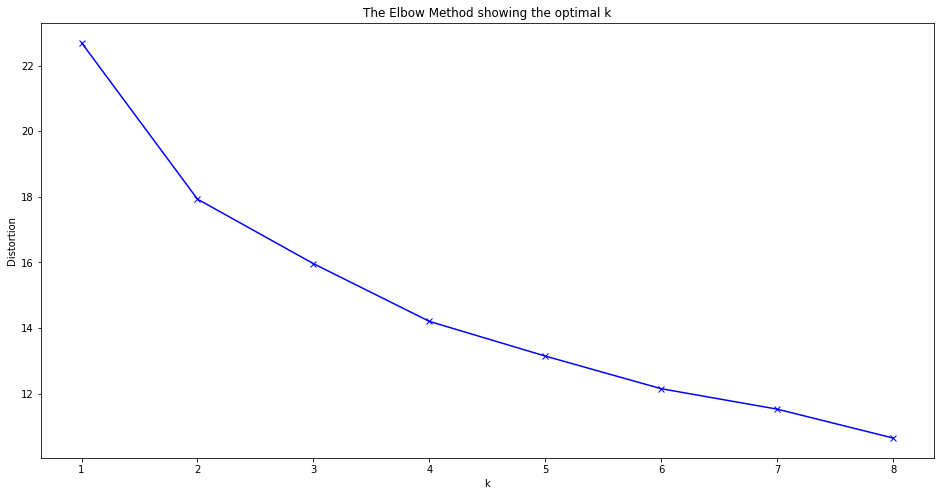

In [21]:

###Optimal K using elbow method
distortions = []
K = range(1, 9)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(
        toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

%matplotlib inline

plt.figure(figsize=(16, 8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

We'll Set K= 4

In [22]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 0, 3, 0, 3, 3, 3, 0, 3], dtype=int32)

####Removing neighborhoods that do not contain any venues

In [23]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_new

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,LA NOTRE,TIM HORTONS,FIRST BREAK COFFEE SHOP,ESPRESSO ETC
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,TIM HORTONS,CAFE BELLEVUE,乾隆茶社 LONG TEA,FIX
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3.0,TIM HORTONS,STARBUCKS,DARK HORSE ESPRESSO BAR,MERCHANTS OF GREEN COFFEE
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,1.0,TIM HORTONS,THE GREEN UMBRELLA CAFE,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494,3.0,TIM HORTONS,SECOND CUP,STARBUCKS,AROMA ESPRESSO BAR


In [24]:
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
45,M2L,North York,"York Mills, Silver Hills",43.757490,-79.374714,NaN,NaN,NaN,NaN,NaN
50,M9L,North York,Humber Summit,43.756303,-79.565963,NaN,NaN,NaN,NaN,NaN
51,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476,NaN,NaN,NaN,NaN,NaN
57,M9M,North York,"Humberlea, Emery",43.724766,-79.532242,NaN,NaN,NaN,NaN,NaN
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509,NaN,NaN,NaN,NaN,NaN


In [25]:
toronto_merged.dropna(subset = ["Cluster Labels"], inplace=True)

##Map

###Visial Display of Neighborhoods in Toronto

In [26]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [27]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_new['Latitude'], df_new['Longitude'], df_new['Borough'], df_new['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

###Visual display of clusters of Toronto neighborhoods with similar coffee shops.

In [28]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['blue', 'orange', 'red', 'yellow', 'black', 'cadetblue']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [29]:
map_clusters.save("map_clusters.html")

# Results and Discussion <a name="results and discussion"></a>
Clusters 0, 1, 2, 3 in the map below are mapped to --> 1, 2, 3, 4 in this section.

###Cluster 1 (Red Points)

In [30]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
10,Glencairn,0.0,STARBUCKS,TIM HORTONS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
16,Humewood-Cedarvale,0.0,STARBUCKS,JACK'S BAKERY AND PASTRY,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",0.0,STARBUCKS,TIM HORTONS,CAFE SYMPATICO,乾隆茶社 LONG TEA
18,"Guildwood, Morningside, West Hill",0.0,STARBUCKS,TIM HORTONS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
23,Leaside,0.0,STARBUCKS,TIM HORTONS,AROMA ESPRESSO BAR,乾隆茶社 LONG TEA
28,"Bathurst Manor, Wilson Heights, Downsview North",0.0,STARBUCKS,TIM HORTONS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
29,Thorncliffe Park,0.0,TIM HORTONS,STARBUCKS,AROMA ESPRESSO BAR,乾隆茶社 LONG TEA
55,"Bedford Park, Lawrence Manor East",0.0,STARBUCKS,TIM HORTONS,AROMA ESPRESSO BAR,乾隆茶社 LONG TEA
66,York Mills West,0.0,STARBUCKS,TIM HORTONS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
85,"Milliken, Agincourt North, Steeles East, L'Amo...",0.0,STARBUCKS,CHEESE GARDEN,乾隆茶社 LONG TEA,ELCHI CHAI SHOP


We see that cluster 1 has Tim Hortons and StarBucks as the most popular chains.

###Cluster 2 (Purple Points)

In [31]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
0,Parkwoods,1.0,LA NOTRE,TIM HORTONS,FIRST BREAK COFFEE SHOP,ESPRESSO ETC
1,Victoria Village,1.0,TIM HORTONS,CAFE BELLEVUE,乾隆茶社 LONG TEA,FIX
3,"Lawrence Manor, Lawrence Heights",1.0,TIM HORTONS,THE GREEN UMBRELLA CAFE,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP
6,"Malvern, Rouge",1.0,TIM HORTONS,SECOND CUP,乾隆茶社 LONG TEA,FIRST AND LAST COFFEE SHOP
26,Cedarbrae,1.0,TIM HORTONS,COFFEE CULTURE CAFE & EATERY,乾隆茶社 LONG TEA,ELLA'S UNCLE
27,Hillcrest Village,1.0,TIM HORTONS,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP,ESPRESSO ETC
32,Scarborough Village,1.0,GREAT STYLE DONUTS & SUBS,TIM HORTONS,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP
34,"Northwood Park, York University",1.0,TIM HORTONS,STARBUCKS,乾隆茶社 LONG TEA,ELCHI CHAI SHOP
38,"Kennedy Park, Ionview, East Birchmount Park",1.0,TIM HORTONS,COUNTRY STYLE,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP
40,Downsview East,1.0,TIM HORTONS,COFFEE TIME,SECOND CUP,乾隆茶社 LONG TEA


We see in Cluster 2 there aren't as many StarBucks chain as compared to Cluster 1.

###Cluster 3 (Teal Points)

In [32]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
46,Downsview West,2.0,COUNTRY STYLE,乾隆茶社 LONG TEA,FIX,ESPRESSO ETC
70,Westmount,2.0,COUNTRY STYLE,STARBUCKS,乾隆茶社 LONG TEA,FIRST AND LAST COFFEE SHOP
77,"Kingsview Village, St. Phillips, Martin Grove ...",2.0,COUNTRY STYLE,乾隆茶社 LONG TEA,FIX,ESPRESSO ETC


Cluster 3 has Country Style as the most widely available coffee chain. Tim Hortons is not as widely avaialble here. \
**This area (Neighborhoods: Downsview West, Westmount and Kingsview Village) seems to be most suitable to open up Tim Hortons.**

###Cluster 4 (Yellow Points)

In [33]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Coffee,2nd Most Common Coffee,3rd Most Common Coffee,4th Most Common Coffee
2,"Regent Park, Harbourfront",3.0,TIM HORTONS,STARBUCKS,DARK HORSE ESPRESSO BAR,MERCHANTS OF GREEN COFFEE
4,Ontario Provincial Government,3.0,TIM HORTONS,SECOND CUP,STARBUCKS,AROMA ESPRESSO BAR
5,Islington Avenue,3.0,JAVA JOE'S VILLAGE CAFE,乾隆茶社 LONG TEA,FIRST BREAK COFFEE SHOP,ESPRESSO ETC
7,Don Mills North,3.0,BARETTO CAFFÉ,COUNTRY STYLE,POSTMEDIA CAFETERIA,STARBUCKS
8,"Parkview Hill, Woodbine Gardens",3.0,TIM HORTONS,COUNTRY STYLE,BEANWISE (FORMERLY CULTURED COFFEE BEAN),SECOND CUP
9,"Garden District, Ryerson",3.0,TIM HORTONS,STARBUCKS,SECOND CUP,AROMA ESPRESSO BAR
11,"West Deane Park, Princess Gardens, Martin Grov...",3.0,MY DAILY GRIND,STARBUCKS,VICTORIAN GARDEN TEA ROOM,DELIMARK CAFE
12,"Rouge Hill, Port Union, Highland Creek",3.0,HIGHLAND HARVEST,乾隆茶社 LONG TEA,ESPRESSO ETC,EURO CREPE CAFE
13,Don Mills South,3.0,DELIMARK CAFE,TIM HORTONS,MARIA'S CORNER CAFE,ANTHONY'S CAFE
14,Woodbine Heights,3.0,TIM HORTONS,LAST DROP CAFE,TEGH CAFE ON 4,STARBUCKS


Cluster 4 has a good mix of Tim Horton's, StarBucks, and Second Cup Chains.

#Conclusion <a name="conclusion"></a>

 **This project was good practice to utilize data science to find a solution to a business problem. Numerous Python libraries were used to scrape data from multiple online sources, apply cleaning methods on the data set and merging them to a master data set, visualize those datasets, apply feature engineering (one hot encoding) to make the data set suitable for to implement a machine learning algorithm (k-means) to group neighborhoods with similar coffee profiles. \
 We  utilized Foursquare API to obtain venues dataand utilized Folium to display neighborhood latitude and longitides  on a map. \
This project can be additionally improved with information regarding demographics and population data.**